#  Классификация текстов с использованием эмбеддингов слов.

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://rusvectores.org/
* https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
* https://github.com/natasha/navec
* https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
* https://torchmetrics.readthedocs.io/en/stable/

## Задачи для совместного разбора

1\. Реализуйте модель для классификации текстов с использованием слоя `nn.Embedding`. Заморозьте веса слоя эмбеддингов.

In [ ]:
import torch as th
import torch.nn as nn

In [ ]:
n_tokens = 1000
batch_size = 16
seq_len = 20

X = th.randint(0, n_tokens, size=(batch_size, seq_len))
y = th.full(size=(16, ), fill_value=0.5).bernoulli().long()

In [ ]:
class Net(nn.Module):
  def __init__(self, num_embeddings: int, embedding_dim: int, num_hidden:int = 8, num_classes: int = 2):
    super().__init__()
    self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_idx=0,)
    # from_pretrained
    self.fc = nn.Sequential(
        nn.Linear(embedding_dim, num_hidden),
        nn.ReLU(),
        nn.Linear(num_hidden, num_classes),
    )

  def forward(self, X):
    # X: (b x s)
    tokens_emb = self.embedding(X) # (batch x seq x emb)
    sent_emb = tokens_emb.mean(dim=1) # (b x e)
    logits = self.fc(sent_emb) # (b x c)
    return logits

In [ ]:
model = Net(num_embeddings=n_tokens, embedding_dim=32, num_classes=2)
logits = model(X)
logits[:5, :]

tensor([[-0.1223, -0.2923],
        [-0.1819, -0.3385],
        [-0.1449, -0.2764],
        [-0.1134, -0.2629],
        [-0.1049, -0.2330]], grad_fn=<SliceBackward0>)

In [ ]:
criterion = nn.CrossEntropyLoss()
criterion(logits, y)

tensor(0.6970, grad_fn=<NllLossBackward0>)

In [ ]:
model.embedding.weight.requires_grad_(False)

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-1.0764, -0.3546,  0.1170,  ...,  0.6116, -0.2833,  1.1368],
        [ 0.0286, -0.4521,  1.0405,  ..., -1.3876,  1.2065,  2.1588],
        ...,
        [-1.4045, -0.7926, -0.2063,  ..., -0.0232, -1.9989, -0.9711],
        [-0.1173,  0.5138,  0.4972,  ..., -0.4553, -0.7452,  0.8303],
        [-0.1327,  2.2378, -0.1567,  ...,  0.4253,  0.1380,  2.6849]])

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Считайте файл `lenta_news.csv` и разбейте на обучающую и тестовую выборку. Выполните предобработку текста и создайте Tokenizer на основе обучающей выборки (токен - слово). Выведите на экран количество токенов в полученном словаре. Обратите внимание, что построение словаря токенов должно производиться исключительно на основе обучающей выборки.

- [ ] Проверено на семинаре

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import nltk
import re

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NLP/7/lenta_news.csv')
df

,title,text,topic
0,МВД создало бюро по борьбе с отмыванием денег,В МВД России создано оперативно-розыскное бюро...,Экономика
1,Правительство не будет занимать деньги у ЦБ,Правительство не будет прибегать к заимствован...,Экономика
2,"ВВС США заказали 60 ""Боингов"" для вторжения в ...",Компания Boeing получит пятилетний контракт на...,Экономика
3,Правительственная комиссия не дала ExxonMobil ...,Результаты конкурса на право освоения месторож...,Экономика
4,Неимущим для получения пособия придется расста...,В доходах малоимущих россиян будут учитываться...,Экономика
...,...,...,...
23944,"Борис Гребенщиков награжден орденом ""За заслуг...","Лидер легендарной группы ""Аквариум"" Борис Греб...",Культура
23945,Мадонна и Траволта названы худшими актерами года,"24 марта, накануне вручения премии Американско...",Культура
23946,Габриэль Гарсиа Маркес простил Голливуд ради д...,Габриэль Гарсиа Маркес,Культура
23947,Аль Пачино отстоял в суде свое право на детей,Знаменитый американский актер Аль Пачино добил...,Культура


In [ ]:
df['topic'].unique()

array(['Экономика', 'Интернет и СМИ', 'Спорт', 'Культура'], dtype=object)

In [ ]:
X = df['text'].astype(str)
y = df['topic']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
all_tokens = []

def preprocess_text(text):
    text = re.sub(r'[^а-яё\s]', ' ', text.lower())
    tokens = word_tokenize(text)
    return tokens


for text in X_train:
    tokens = preprocess_text(text)
    all_tokens.extend(tokens)

In [ ]:
token_counts = Counter(all_tokens)

In [ ]:
vocab = {token: idx+2 for idx, (token, count) in enumerate(token_counts.items())}
vocab['<unk>'] = 1
vocab['<pad>'] = 0

In [ ]:
len(vocab)

165608

<p class="task" id="2"></p>


2\. Создайте класс `NewsDataset`. Реализуйте метод `__getitem__` таким образом, чтобы он возвращал набор индексов токенов для текста новости $i$ и метку класса для этой новости. Сделайте длины наборов индексов одинаковой фиксированной длины (подходящее значение определите сами). Закодируйте целыми числами категории новостей. Создайте два объекта класса `NewsDataset` (для обучающей и тестовой выборки).

Выведите на экран результат выполнения `train_dataset[0]`

- [ ] Проверено на семинаре

In [ ]:
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
tokenized_train = [preprocess_text(text) for text in X_train]
max_len = max(len(tokens) for tokens in tokenized_train)
max_len

875

In [ ]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def encode_text(self, text):
        tokens = preprocess_text(text)
        ids = [self.vocab.get(token, self.vocab['<unk>']) for token in tokens]
        if len(ids) < self.max_len:
            ids += [self.vocab['<pad>']] * (self.max_len - len(ids))
        else:
            ids = ids[:self.max_len]
        return ids

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels[idx]
        token_ids = self.encode_text(text)
        return torch.tensor(token_ids, dtype=torch.long), torch.tensor(label, dtype=torch.long)

In [ ]:
train_dataset = NewsDataset(X_train, y_train_encoded, vocab, max_len)
test_dataset = NewsDataset(X_test, y_test_encoded, vocab, max_len)


In [ ]:
tokens_tensor, label_tensor = train_dataset[0]
tokens_tensor


tensor([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  11,  13,  14,
         15,  16,  17,  18,  19,  11,  20,  21,  22,  11,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  29,  30,   7,   9,  47,  27,  48,  49,
         50,  11,  51,  52,  53,  54,   7,   9,  55,  11,  56,  11,  57,  26,
         58,  20,  11,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  11,  85,  86,  87,  88,  89,  90,  91,  92,  11,  93,  94,  95,
         45,  96,  97,  26,  98,  99, 100,  11, 101, 102, 103, 104, 105, 106,
          5,   6,  11, 107, 108, 109, 110, 111, 112, 113, 114, 115,  29, 116,
        117,  11, 118,  11, 119, 120, 121, 122, 123,  27, 124, 125, 126,  11,
         56,   7,   9,  10, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
        137, 138, 139, 140, 141,  26, 142, 143,   0,   0,   0,  

In [ ]:
label_tensor

tensor(1)

<p class="task" id="3"></p>

3\. Реализуйте модель, которая получает на вход батч новостей (в виде индексов токенов), пропускает его через слой `nn.Embedding` (матрица эмбеддингов инициализируется случайным образом), после чего передает полученные эмбеддинги части-классификатору (который состоит из некоторого количества полносвязных слоев). Для получения эмбеддинга для новости на основе эмбеддингов слов воспользуйтесь любой функцией агрегации, сохраняющей размерности векторов (сумма, усреднение и т.д.).

Решите задачу классификации новостей. Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики f1 на обучающем и тестовом множестве в зависимости от эпохи. Выведите на экран отчет по классификации на обучающем и тестовом множестве.

- [ ] Проверено на семинаре

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, classification_report, accuracy_score
import matplotlib.pyplot as plt

In [ ]:
batch = 16
emb_dim = 100
num_classes = len(label_encoder.classes_)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device, num_classes

(device(type='cuda'), 4)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch)

```
  def forward(self, X):
    # X: (b x s)
    tokens_emb = self.embedding(X) # (batch x seq x emb)
    sent_emb = tokens_emb.mean(dim=1) # (b x e)
    logits = self.fc(sent_emb) # (b x c)
    return logits

```

In [ ]:
class Classifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=vocab['<pad>'])
        self.fc1 = nn.Linear(emb_dim, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)                     # (batch x seq x emb)
        x = embedded.mean(dim=1)                         # (b x e)
        x = F.relu(self.fc1(x))                          # (B, 128)
        x = self.fc2(x)                                  # (b x c)
        return x


model = Classifier(vocab_size=len(vocab), emb_dim=emb_dim, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
epochs = 10

In [ ]:
from tqdm import tqdm

train_losses, train_f1s, test_f1s = [], [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    for x_batch, y_batch in loop:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1).cpu()
        all_preds.extend(preds)
        all_labels.extend(y_batch.cpu())

        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    f1_train = f1_score(all_labels, all_preds, average='macro')
    acc_train = accuracy_score(all_labels, all_preds)

    train_losses.append(avg_loss)
    train_f1s.append(f1_train)
    train_accuracies.append(acc_train)

    # Тест
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch)
            preds = torch.argmax(logits, dim=1).cpu()
            test_preds.extend(preds)
            test_labels.extend(y_batch.cpu())

    f1_test = f1_score(test_labels, test_preds, average='macro')
    acc_test = accuracy_score(test_labels, test_preds)

    test_f1s.append(f1_test)
    test_accuracies.append(acc_test)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} "
          f"| F1 Train: {f1_train:.4f} | F1 Test: {f1_test:.4f} "
          f"| Acc Train: {acc_train:.4f} | Acc Test: {acc_test:.4f}")


Epoch 1/10 | Loss: 0.6375 | F1 Train: 0.7892 | F1 Test: 0.9198 | Acc Train: 0.7865 | Acc Test: 0.9198


Epoch 2/10 | Loss: 0.1494 | F1 Train: 0.9548 | F1 Test: 0.9454 | Acc Train: 0.9548 | Acc Test: 0.9455


Epoch 3/10 | Loss: 0.0690 | F1 Train: 0.9827 | F1 Test: 0.9510 | Acc Train: 0.9827 | Acc Test: 0.9511


Epoch 4/10 | Loss: 0.0330 | F1 Train: 0.9923 | F1 Test: 0.9497 | Acc Train: 0.9923 | Acc Test: 0.9497


Epoch 5/10 | Loss: 0.0161 | F1 Train: 0.9971 | F1 Test: 0.9528 | Acc Train: 0.9971 | Acc Test: 0.9528


Epoch 6/10 | Loss: 0.0086 | F1 Train: 0.9984 | F1 Test: 0.9523 | Acc Train: 0.9984 | Acc Test: 0.9524


Epoch 7/10 | Loss: 0.0052 | F1 Train: 0.9990 | F1 Test: 0.9519 | Acc Train: 0.9990 | Acc Test: 0.9520


Epoch 8/10 | Loss: 0.0035 | F1 Train: 0.9992 | F1 Test: 0.9521 | Acc Train: 0.9992 | Acc Test: 0.9522


Epoch 9/10 | Loss: 0.0026 | F1 Train: 0.9993 | F1 Test: 0.9521 | Acc Train: 0.9993 | Acc Test: 0.9522


Epoch 10/10 | Loss: 0.0022 | F1 Train: 0.9992 | F1 Test: 0.9534 | Acc Train: 0.9992 | Acc Test: 0.9534


In [ ]:
# 6+ min
metrics_1 = [train_losses, train_f1s, test_f1s, train_accuracies, test_accuracies]

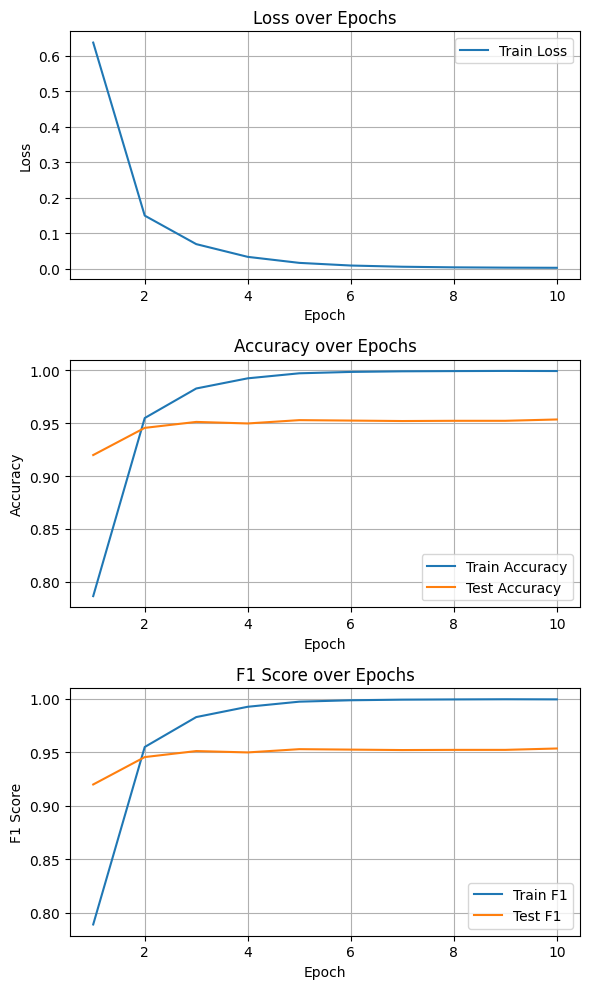

In [ ]:
epochs_range = list(range(1, epochs + 1))

plt.figure(figsize=(6, 10))

# 1. Loss
plt.subplot(3, 1, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.grid()
plt.legend()

# 2. Accuracy
plt.subplot(3, 1, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.grid()
plt.legend()

# 3. F1 Score
plt.subplot(3, 1, 3)
plt.plot(epochs_range, train_f1s, label='Train F1')
plt.plot(epochs_range, test_f1s, label='Test F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score over Epochs')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

<p class="task" id="4"></p>

4\. Повторите решение задачи 3, создав слой `nn.Embedding` на основе предобученных векторов для слов русского языка и заморозив веса данного слоя. Для поиска векторов можете воспользоваться любым известным вам ресурсом. Сравните качество полученного решения и решения из предыдущей задачи, а также время, затраченное на обучения моделей.  

- [ ] Проверено на семинаре

In [ ]:

import gzip
embeddings = []
words = dict()
with gzip.open("/content/drive/MyDrive/NLP/5/ruscorpora_upos_skipgram_300_5_2018.vec", "rt", encoding='UTF-8') as fp:
  fp.readline()
  for idx, line in enumerate(fp):
    word_pos, v = line.split(" ", maxsplit=1)
    word, pos = word_pos.split("_")
    emb = [float(n) for n in v.split(" ")]
    embeddings.append(emb)
    words[(word, pos)] = idx
embeddings = torch.tensor(embeddings)

In [ ]:
unk_vector = torch.full((1, 300), 1/300)
pad_vector = torch.zeros((1, 300))
embeddings = torch.cat([pad_vector, unk_vector, embeddings], dim=0)


In [ ]:
class ClassifierPretrained(nn.Module):
    def __init__(self, embedding_matrix, num_classes):
        super().__init__()
        num_embeddings, embed_dim = embedding_matrix.shape

        self.embedding = nn.Embedding.from_pretrained(
            embeddings=torch.tensor(embedding_matrix, dtype=torch.float32),
            freeze=True,
            padding_idx=vocab['<pad>']
        )
        self.embedding.weight.data[1] = torch.full((300,), 1/300)

        self.fc1 = nn.Linear(embed_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        x = embedded.mean(dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
model = ClassifierPretrained(embeddings, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

<ipython-input-191-6724842188e8>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings=torch.tensor(embedding_matrix, dtype=torch.float32),


In [ ]:
epochs = 20

In [ ]:
from tqdm import tqdm

train_losses, train_f1s, test_f1s = [], [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    for x_batch, y_batch in loop:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1).cpu()
        all_preds.extend(preds)
        all_labels.extend(y_batch.cpu())

        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    f1_train = f1_score(all_labels, all_preds, average='macro')
    acc_train = accuracy_score(all_labels, all_preds)

    train_losses.append(avg_loss)
    train_f1s.append(f1_train)
    train_accuracies.append(acc_train)

    # Тест
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch)
            preds = torch.argmax(logits, dim=1).cpu()
            test_preds.extend(preds)
            test_labels.extend(y_batch.cpu())

    f1_test = f1_score(test_labels, test_preds, average='macro')
    acc_test = accuracy_score(test_labels, test_preds)

    test_f1s.append(f1_test)
    test_accuracies.append(acc_test)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} "
          f"| F1 Train: {f1_train:.4f} | F1 Test: {f1_test:.4f} "
          f"| Acc Train: {acc_train:.4f} | Acc Test: {acc_test:.4f}")


Epoch 1/20 | Loss: 1.3736 | F1 Train: 0.3278 | F1 Test: 0.3098 | Acc Train: 0.3274 | Acc Test: 0.3764


Epoch 2/20 | Loss: 1.2581 | F1 Train: 0.5076 | F1 Test: 0.5333 | Acc Train: 0.5198 | Acc Test: 0.5518


Epoch 3/20 | Loss: 1.0958 | F1 Train: 0.5892 | F1 Test: 0.6516 | Acc Train: 0.6015 | Acc Test: 0.6516


Epoch 4/20 | Loss: 0.9848 | F1 Train: 0.6277 | F1 Test: 0.6018 | Acc Train: 0.6362 | Acc Test: 0.6242


Epoch 5/20 | Loss: 0.9132 | F1 Train: 0.6505 | F1 Test: 0.6767 | Acc Train: 0.6563 | Acc Test: 0.6804


Epoch 6/20 | Loss: 0.8627 | F1 Train: 0.6660 | F1 Test: 0.6964 | Acc Train: 0.6700 | Acc Test: 0.6981


Epoch 7/20 | Loss: 0.8259 | F1 Train: 0.6808 | F1 Test: 0.6981 | Acc Train: 0.6836 | Acc Test: 0.7017


Epoch 8/20 | Loss: 0.7961 | F1 Train: 0.6952 | F1 Test: 0.6978 | Acc Train: 0.6972 | Acc Test: 0.7054


Epoch 9/20 | Loss: 0.7738 | F1 Train: 0.7024 | F1 Test: 0.7128 | Acc Train: 0.7041 | Acc Test: 0.7165


Epoch 10/20 | Loss: 0.7530 | F1 Train: 0.7105 | F1 Test: 0.7349 | Acc Train: 0.7119 | Acc Test: 0.7344


Epoch 11/20 | Loss: 0.7377 | F1 Train: 0.7149 | F1 Test: 0.7352 | Acc Train: 0.7163 | Acc Test: 0.7365


Epoch 12/20 | Loss: 0.7232 | F1 Train: 0.7223 | F1 Test: 0.7399 | Acc Train: 0.7233 | Acc Test: 0.7409


Epoch 13/20 | Loss: 0.7112 | F1 Train: 0.7273 | F1 Test: 0.7465 | Acc Train: 0.7283 | Acc Test: 0.7474


Epoch 14/20 | Loss: 0.6998 | F1 Train: 0.7313 | F1 Test: 0.7548 | Acc Train: 0.7323 | Acc Test: 0.7555


Epoch 15/20 | Loss: 0.6900 | F1 Train: 0.7365 | F1 Test: 0.7506 | Acc Train: 0.7372 | Acc Test: 0.7524


Epoch 16/20 | Loss: 0.6833 | F1 Train: 0.7374 | F1 Test: 0.7562 | Acc Train: 0.7382 | Acc Test: 0.7574


Epoch 17/20 | Loss: 0.6727 | F1 Train: 0.7423 | F1 Test: 0.7601 | Acc Train: 0.7430 | Acc Test: 0.7614


Epoch 18/20 | Loss: 0.6676 | F1 Train: 0.7446 | F1 Test: 0.7628 | Acc Train: 0.7453 | Acc Test: 0.7614


Epoch 19/20 | Loss: 0.6611 | F1 Train: 0.7498 | F1 Test: 0.7633 | Acc Train: 0.7505 | Acc Test: 0.7658


Epoch 20/20 | Loss: 0.6539 | F1 Train: 0.7524 | F1 Test: 0.7650 | Acc Train: 0.7530 | Acc Test: 0.7672


In [ ]:
# 11+ минут
metrics_2 = [train_losses, train_f1s, test_f1s, train_accuracies, test_accuracies]

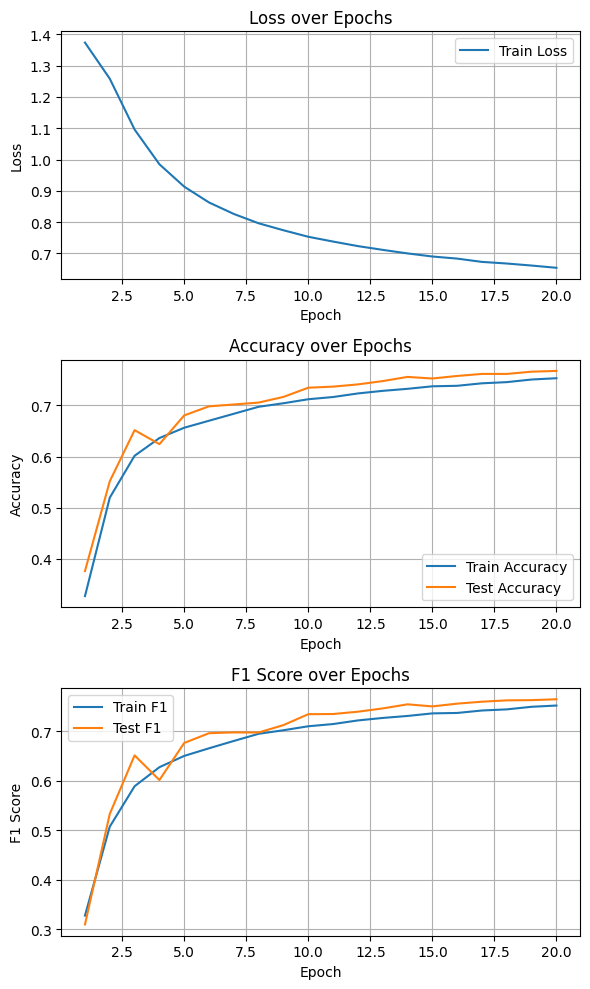

In [ ]:
epochs_range = list(range(1, epochs + 1))

plt.figure(figsize=(6, 10))

# 1. Loss
plt.subplot(3, 1, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.grid()
plt.legend()

# 2. Accuracy
plt.subplot(3, 1, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.grid()
plt.legend()

# 3. F1 Score
plt.subplot(3, 1, 3)
plt.plot(epochs_range, train_f1s, label='Train F1')
plt.plot(epochs_range, test_f1s, label='Test F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score over Epochs')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

<p class="task" id="5"></p>

5\. Повторите решение задачи 3, не замораживая веса слоя эмбеддингов. Сравните качество полученного решения и решений из предыдущих задач, а также время, затраченное на обучения моделей.  

- [ ] Проверено на семинаре

In [ ]:
class ClassifierPretrained(nn.Module):
    def __init__(self, embedding_matrix, num_classes):
        super().__init__()
        num_embeddings, embed_dim = embedding_matrix.shape

        self.embedding = nn.Embedding.from_pretrained(
            embeddings=torch.tensor(embedding_matrix, dtype=torch.float32),
            freeze=False,
            padding_idx=vocab['<pad>']
        )
        self.embedding.weight.data[1] = torch.full((300,), 1/300)

        self.fc1 = nn.Linear(embed_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        x = embedded.mean(dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
model = ClassifierPretrained(embeddings, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

<ipython-input-198-37d2b925784b>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings=torch.tensor(embedding_matrix, dtype=torch.float32),


In [ ]:
epochs = 20

In [ ]:
from tqdm import tqdm

train_losses, train_f1s, test_f1s = [], [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    for x_batch, y_batch in loop:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1).cpu()
        all_preds.extend(preds)
        all_labels.extend(y_batch.cpu())

        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    f1_train = f1_score(all_labels, all_preds, average='macro')
    acc_train = accuracy_score(all_labels, all_preds)

    train_losses.append(avg_loss)
    train_f1s.append(f1_train)
    train_accuracies.append(acc_train)

    # Тест
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch)
            preds = torch.argmax(logits, dim=1).cpu()
            test_preds.extend(preds)
            test_labels.extend(y_batch.cpu())

    f1_test = f1_score(test_labels, test_preds, average='macro')
    acc_test = accuracy_score(test_labels, test_preds)

    test_f1s.append(f1_test)
    test_accuracies.append(acc_test)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} "
          f"| F1 Train: {f1_train:.4f} | F1 Test: {f1_test:.4f} "
          f"| Acc Train: {acc_train:.4f} | Acc Test: {acc_test:.4f}")


Epoch 1/20 | Loss: 0.4297 | F1 Train: 0.8484 | F1 Test: 0.9629 | Acc Train: 0.8469 | Acc Test: 0.9630


Epoch 2/20 | Loss: 0.0566 | F1 Train: 0.9855 | F1 Test: 0.9707 | Acc Train: 0.9855 | Acc Test: 0.9708


Epoch 3/20 | Loss: 0.0149 | F1 Train: 0.9971 | F1 Test: 0.9682 | Acc Train: 0.9971 | Acc Test: 0.9683


Epoch 4/20 | Loss: 0.0055 | F1 Train: 0.9989 | F1 Test: 0.9686 | Acc Train: 0.9989 | Acc Test: 0.9687


Epoch 5/20 | Loss: 0.0029 | F1 Train: 0.9994 | F1 Test: 0.9688 | Acc Train: 0.9994 | Acc Test: 0.9689


Epoch 6/20 | Loss: 0.0022 | F1 Train: 0.9993 | F1 Test: 0.9713 | Acc Train: 0.9993 | Acc Test: 0.9714


Epoch 7/20 | Loss: 0.0019 | F1 Train: 0.9994 | F1 Test: 0.9703 | Acc Train: 0.9994 | Acc Test: 0.9704


Epoch 8/20 | Loss: 0.0017 | F1 Train: 0.9994 | F1 Test: 0.9688 | Acc Train: 0.9994 | Acc Test: 0.9689


Epoch 9/20 | Loss: 0.0016 | F1 Train: 0.9993 | F1 Test: 0.9686 | Acc Train: 0.9993 | Acc Test: 0.9687


Epoch 10/20 | Loss: 0.0014 | F1 Train: 0.9994 | F1 Test: 0.9691 | Acc Train: 0.9994 | Acc Test: 0.9691


Epoch 11/20 | Loss: 0.0014 | F1 Train: 0.9995 | F1 Test: 0.9688 | Acc Train: 0.9995 | Acc Test: 0.9689


Epoch 12/20 | Loss: 0.0013 | F1 Train: 0.9995 | F1 Test: 0.9686 | Acc Train: 0.9995 | Acc Test: 0.9687


Epoch 13/20 | Loss: 0.0013 | F1 Train: 0.9995 | F1 Test: 0.9675 | Acc Train: 0.9995 | Acc Test: 0.9676


Epoch 14/20 | Loss: 0.0011 | F1 Train: 0.9995 | F1 Test: 0.9659 | Acc Train: 0.9995 | Acc Test: 0.9660


Epoch 15/20 | Loss: 0.0012 | F1 Train: 0.9995 | F1 Test: 0.9682 | Acc Train: 0.9995 | Acc Test: 0.9683


Epoch 16/20 | Loss: 0.0011 | F1 Train: 0.9994 | F1 Test: 0.9682 | Acc Train: 0.9994 | Acc Test: 0.9683


Epoch 17/20 | Loss: 0.0011 | F1 Train: 0.9995 | F1 Test: 0.9673 | Acc Train: 0.9995 | Acc Test: 0.9674


Epoch 18/20 | Loss: 0.0011 | F1 Train: 0.9994 | F1 Test: 0.9649 | Acc Train: 0.9994 | Acc Test: 0.9651


Epoch 19/20 | Loss: 0.0011 | F1 Train: 0.9994 | F1 Test: 0.9639 | Acc Train: 0.9994 | Acc Test: 0.9641


Epoch 20/20 | Loss: 0.0011 | F1 Train: 0.9994 | F1 Test: 0.9626 | Acc Train: 0.9994 | Acc Test: 0.9628


In [ ]:
# 18-20 min
metrics_3 = [train_losses, train_f1s, test_f1s, train_accuracies, test_accuracies]

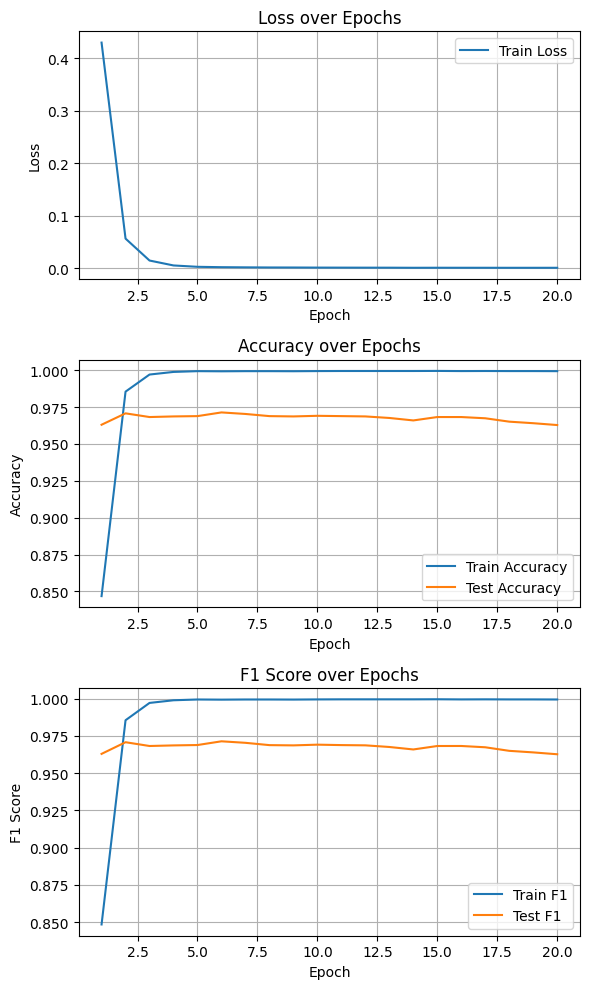

In [ ]:
epochs_range = list(range(1, epochs + 1))

plt.figure(figsize=(6, 10))

# 1. Loss
plt.subplot(3, 1, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.grid()
plt.legend()

# 2. Accuracy
plt.subplot(3, 1, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.grid()
plt.legend()

# 3. F1 Score
plt.subplot(3, 1, 3)
plt.plot(epochs_range, train_f1s, label='Train F1')
plt.plot(epochs_range, test_f1s, label='Test F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score over Epochs')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

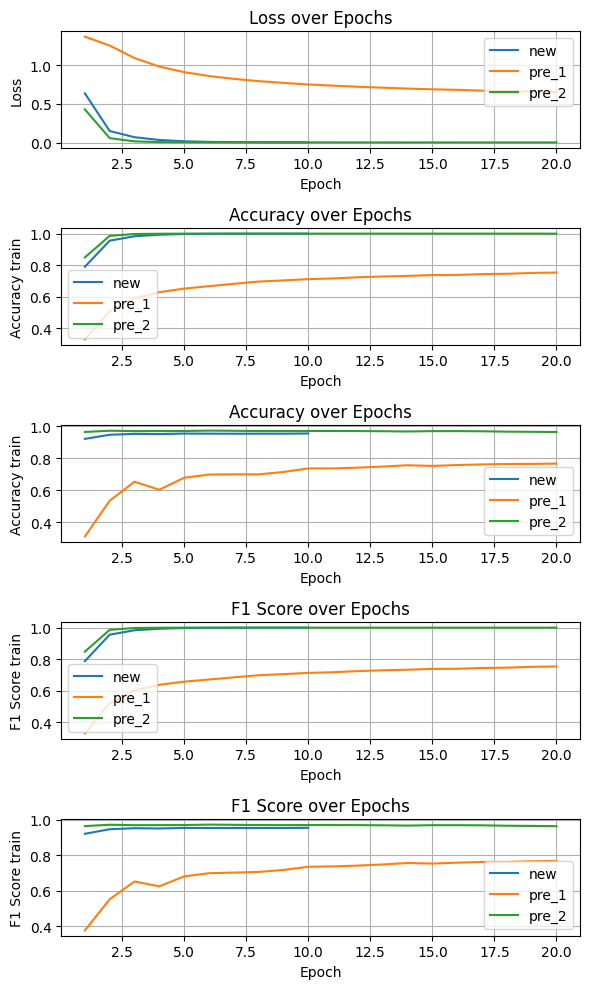

In [ ]:
epochs_range = list(range(1, epochs + 1))
epochs_1 = list(range(1, 10 + 1))
plt.figure(figsize=(6, 10))

# Loss
plt.subplot(5, 1, 1)
plt.plot(epochs_1, metrics_1[0], label='new')
plt.plot(epochs_range, metrics_2[0], label='pre_1')
plt.plot(epochs_range, metrics_3[0], label='pre_2')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.grid()
plt.legend()

# Accuracy train
plt.subplot(5, 1, 2)
plt.plot(epochs_1, metrics_1[1], label='new')
plt.plot(epochs_range, metrics_2[1], label='pre_1')
plt.plot(epochs_range, metrics_3[1], label='pre_2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy train')
plt.title('Accuracy over Epochs')
plt.grid()
plt.legend()

# Accuracy test
plt.subplot(5, 1, 3)
plt.plot(epochs_1, metrics_1[2], label='new')
plt.plot(epochs_range, metrics_2[2], label='pre_1')
plt.plot(epochs_range, metrics_3[2], label='pre_2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy train')
plt.title('Accuracy over Epochs')
plt.grid()
plt.legend()

# F1 Score train
plt.subplot(5, 1, 4)
plt.plot(epochs_1, metrics_1[3], label='new')
plt.plot(epochs_range, metrics_2[3], label='pre_1')
plt.plot(epochs_range, metrics_3[3], label='pre_2')
plt.xlabel('Epoch')
plt.ylabel('F1 Score train')
plt.title('F1 Score over Epochs')
plt.grid()
plt.legend()


# F1 Score test
plt.subplot(5, 1, 5)
plt.plot(epochs_1, metrics_1[4], label='new')
plt.plot(epochs_range, metrics_2[4], label='pre_1')
plt.plot(epochs_range, metrics_3[4], label='pre_2')
plt.xlabel('Epoch')
plt.ylabel('F1 Score train')
plt.title('F1 Score over Epochs')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

<p class="task" id="6"></p>

6\. Воспользовавшись обученной моделью из предыдущей задачи, визуализируйте эмбеддинги новостей из тестовой выборки в двумерном пространстве. Для проекции точек в двумерное пространство воспользуйтесь алгоритмом t-SNE. Раскрасьте точки в цвет, соответствующий классу новости.

- [ ] Проверено на семинаре

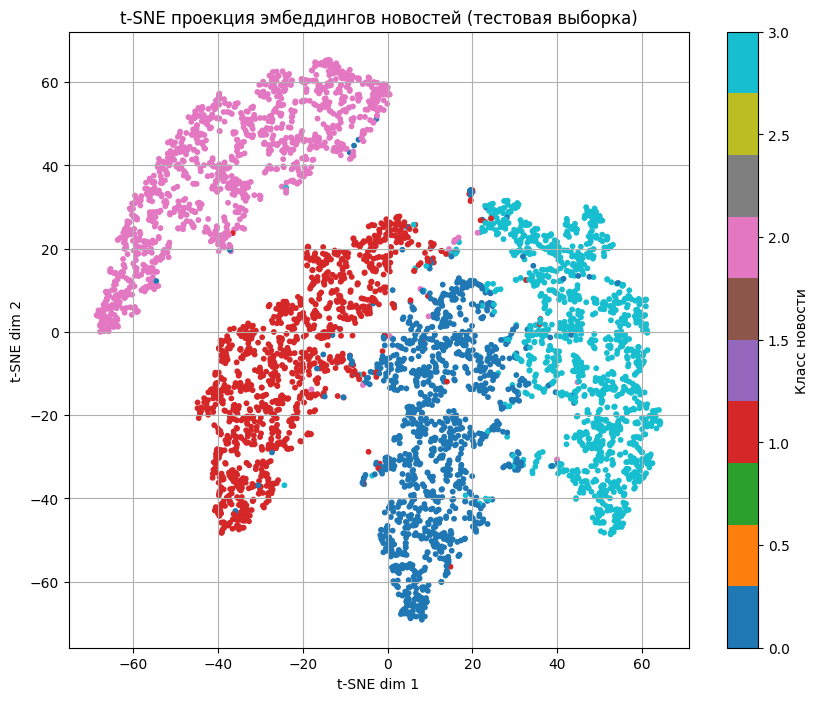

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
from tqdm import tqdm


all_embeddings = []
all_labels = []

model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader, desc="Collecting embeddings"):
        x_batch = x_batch.to(device)

        embedded = model.embedding(x_batch)
        sentence_embeddings = embedded.mean(dim=1)  # (batch_size, embed_dim)

        all_embeddings.append(sentence_embeddings.cpu())
        all_labels.extend(y_batch.numpy())


all_embeddings = torch.cat(all_embeddings, dim=0).numpy()


tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Визуализация
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=all_labels, cmap='tab10', s=10)
plt.title("t-SNE проекция эмбеддингов новостей (тестовая выборка)")
plt.colorbar(scatter, label='Класс новости')
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.grid(True)
plt.show()
